# Manually Construct a TensorRT Engine

With the release of UFF (Universal Framework Format), converting models from compatable frameworks to TensorRT engines is much easier. However, there maybe frameworks that do not currently have UFF exporters or never will. The Python API provides a path forward for Python based frameworks with it's numpy compatable layer weights. 

For this example we are going to be using PyTorch, and show how you can train a model then manually convert the model into a TensorRT engine. 

For python the TensorRT library is refered to as ```tensorrt```, for the Early Access you should have been provided a wheel file with the API, this can be installed by using ```pip``` (e.g. for python2.7 on Ubuntu 16.04- ```pip install tensorrt-3.0.4-cp27-cp27mu-linux_x86_64.whl```). For the Release Canidate forward you can also install the Python API with ```apt-get``` (```apt-get install python-tensorrt```)

You can import tensorrt as you would import any other package

In [1]:
import tensorrt as trt

There are also some common tools that are used with tensorrt typically. We use PyCUDA to handle the CUDA operations needed to allocate memory on your GPU and to transfer data to the GPU and results back to the CPU. We also use numpy as our primary method to store data

In [2]:
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np
from matplotlib.pyplot import imshow #to show test case

We also need to import PyTorch and its various packages

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

## Training a Model in PyTorch

We are going to move quickly through the PyTorch component of this example since it is not the focus. If you want to learn more about PyTorch and how to use it, check out http://pytorch.org/tutorials/

We are going to start out by setting some hyper parameters, then create a dataloader, define our network, set our optimizer and define our train and test steps

In [4]:
BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000
EPOCHS = 3
LEARNING_RATE = 0.001
SGD_MOMENTUM = 0.5  
SEED = 1
LOG_INTERVAL = 100

In [5]:
#Enable Cuda
torch.cuda.manual_seed(SEED)

In [6]:
#Dataloader
kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader  = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/mnist/data', train=True, download=True, 
                    transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,))
        ])),
    batch_size=BATCH_SIZE,
    shuffle=True,
    **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/mnist/data', train=False, 
                   transform=transforms.Compose([
                   transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,))
        ])),
    batch_size=TEST_BATCH_SIZE,
    shuffle=True,
    **kwargs)

In [7]:
#Network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(800, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), kernel_size=2, stride=2)
        x = F.max_pool2d(self.conv2(x), kernel_size=2, stride=2)
        x = x.view(-1, 800)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

model = Net()
model.cuda()

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [8]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=SGD_MOMENTUM)

In [9]:
def train(epoch):
    model.train()
    for batch, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
                 .format(epoch, 
                         batch * len(data), 
                         len(train_loader.dataset), 
                         100. * batch / len(train_loader), 
                         loss.data.item()))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target).data.item()
        pred = output.data.max(1)[1]
        correct += pred.eq(target.data).cpu().sum()
    test_loss /= len(test_loader)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
          .format(test_loss, 
                  correct, 
                  len(test_loader.dataset), 
                  100. * correct / len(test_loader.dataset)))


Now we are going to train this model

In [10]:
for e in range(EPOCHS):
    train(e + 1)
    test(e + 1)

/home/andy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.292546
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.215943
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.077061
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.871375
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.362981
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.869181
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.722393
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.573615
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.530150
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.424118


/home/andy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Test set: Average loss: 0.4000, Accuracy: 8948/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.549394
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.398966
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.351285
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.427161
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.153188
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.319890
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.358238
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.269754
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.260615
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.276815

Test set: Average loss: 0.2694, Accuracy: 9200/10000 (92%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.159606
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.344415
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.259189
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.233190
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.333585
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.224752
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.232293
Train Epoch: 3 [44800/60000 (75%)]	Loss:

## Convert the Model into a TensorRT Engine
Now that we have a "trained" model we are going to start converting the model by first extract the layer wieghts by getting the ```state_dict```

In [11]:
weights = model.state_dict()

Now we are going to start converting the model to TensorRT by first creating a builder and a logger for the build process

In [12]:
G_LOGGER = trt.infer.ConsoleLogger(trt.infer.LogSeverity.ERROR)
builder = trt.infer.create_infer_builder(G_LOGGER)

We are now going to create the network by replicating the network structure above and extracting the weights in the form of numpy arrays from PyTorch. There are more elegant ways of doing this but we have expanded it out to show how it works. The numpy arrays from PyTorch reflect the dimensionality of the layers, so we reshape to flatten the arrays

In [13]:
network = builder.create_network()

#Name for the input layer, data type, tuple for dimension 
data = network.add_input("data", trt.infer.DataType.FLOAT, (1, 28, 28))
assert(data)

#-------------
conv1_w = weights['conv1.weight'].cpu().numpy().reshape(-1)
conv1_b = weights['conv1.bias'].cpu().numpy().reshape(-1)
conv1 = network.add_convolution(data, 20, (5,5),  conv1_w, conv1_b)
assert(conv1)
conv1.set_stride((1,1))

#-------------
pool1 = network.add_pooling(conv1.get_output(0), trt.infer.PoolingType.MAX, (2,2))
assert(pool1)
pool1.set_stride((2,2))

#-------------
conv2_w = weights['conv2.weight'].cpu().numpy().reshape(-1)
conv2_b = weights['conv2.bias'].cpu().numpy().reshape(-1)
conv2 = network.add_convolution(pool1.get_output(0), 50, (5,5), conv2_w, conv2_b)
assert(conv2)
conv2.set_stride((1,1))

#-------------
pool2 = network.add_pooling(conv2.get_output(0), trt.infer.PoolingType.MAX, (2,2))
assert(pool2)
pool2.set_stride((2,2))

#-------------
fc1_w = weights['fc1.weight'].cpu().numpy().reshape(-1)
fc1_b = weights['fc1.bias'].cpu().numpy().reshape(-1)
fc1 = network.add_fully_connected(pool2.get_output(0), 500, fc1_w, fc1_b)
assert(fc1)

#-------------
relu1 = network.add_activation(fc1.get_output(0), trt.infer.ActivationType.RELU)
assert(relu1)

#-------------
fc2_w = weights['fc2.weight'].cpu().numpy().reshape(-1)
fc2_b = weights['fc2.bias'].cpu().numpy().reshape(-1)
fc2 = network.add_fully_connected(relu1.get_output(0), 10, fc2_w, fc2_b)
assert(fc2)

Now we need to mark our output layer

In [14]:
fc2.get_output(0).set_name("prob")
network.mark_output(fc2.get_output(0))

We now are going to set the rest of the parameters for the network (max batch size and max workspace) and build the engine

In [15]:
builder.set_max_batch_size(1)
builder.set_max_workspace_size(1 << 20)

engine = builder.build_cuda_engine(network)
network.destroy()
builder.destroy()

Now we are going to create the engine runtime and generate a test case from the torch dataloader

Test Case: 8


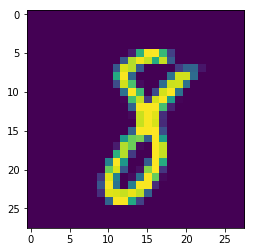

In [16]:
runtime = trt.infer.create_infer_runtime(G_LOGGER)
img, target = next(iter(test_loader))
img = img.numpy()[0]
target = target.numpy()[0]
%matplotlib inline
img.shape
imshow(img[0])
print("Test Case: " + str(target))
img = img.ravel()

We are now going to create an execution context for the engine

In [17]:
context = engine.create_execution_context()

We are going to now allocate the memory on the GPU and allocate memory on the CPU to hold results after inference. The size of the allocations is the size of the input and expected output * the batch size. 

In [18]:
output = np.empty(10, dtype = np.float32)

#alocate device memory
d_input = cuda.mem_alloc(1 * img.size * img.dtype.itemsize)
d_output = cuda.mem_alloc(1 * output.size * output.dtype.itemsize)

The engine needs bindings provided as pointers to the GPU memory. PyCUDA lets us do this for memory allocations by casting those allocations to ints

In [19]:
bindings = [int(d_input), int(d_output)] 

We also are going to create a cuda stream to run inference in.

In [20]:
stream = cuda.Stream()

Now we are going to transfer the data to the GPU, run inference and the copy the results back.

In [21]:
#transfer input data to device
cuda.memcpy_htod_async(d_input, img, stream)
#execute model 
context.enqueue(1, bindings, stream.handle, None)
#transfer predictions back
cuda.memcpy_dtoh_async(output, d_output, stream)
#syncronize threads
stream.synchronize()

Now we have our results. We can just run ArgMax to get a prediction

In [22]:
print("Test Case: " + str(target))
print ("Prediction: " + str(np.argmax(output)))

Test Case: 8
Prediction: 8


We can also save our engine to a file to use later

In [23]:
trt.utils.write_engine_to_file("./pyt_mnist.engine", engine.serialize()) 

True

You can then load this engine later by using ```tensorrt.utils.load_engine```

In [24]:
new_engine = trt.utils.load_engine(G_LOGGER, "./pyt_mnist.engine") 

And as a final step, we are going to clean up our context, engine and runtime

In [25]:
context.destroy()
engine.destroy()
new_engine.destroy()
runtime.destroy()